<a href="https://colab.research.google.com/github/gomezore/as_instagram_bayly/blob/main/AS_INSTAGRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link del modelo Beto: https://huggingface.co/finiteautomata/beto-sentiment-analysis

Link del archivo XLSX: https://docs.google.com/spreadsheets/d/1ScDq2VVsT-gl6TyLE0BHX32GCLukIJ0Igha9tKBjpP0/edit?usp=drive_link




# **Importar dependencias**


In [ ]:
#Instala la libreria
!pip install -q transformers
!pip install pyspark

#Esta línea importa la función pipeline() de la biblioteca Transformers, que se utiliza para cargar y aplicar modelos pre-entrenados de lenguaje natural.
#Esta línea importa la biblioteca Pandas, que proporciona una estructura de datos DataFrame para el análisis de datos.
#Esta línea importa la función col() de la biblioteca PySpark, que se utiliza para seleccionar columnas de un DataFrame Spark.

from transformers import pipeline
import re
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import csv

#se importa la dependencia para la nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

#importa la biblioteca Seaborn, que es una biblioteca de Python para la visualización de datos estadísticos.
#Seaborn proporciona una variedad de funciones para crear gráficos atractivos e informativos, como diagramas de barras etc.
import seaborn as sns

# **Cargar y análisis datos**

In [ ]:
#El código crea una sesión Spark, lee un archivo Excel en un DataFrame Pandas,
#convierte el DataFrame Pandas a un DataFrame Spark y muestra los datos en el DataFrame Spark.

# Create a SparkSession
spark = SparkSession.builder.appName("ReadExcel").getOrCreate()

# Read Excel file into a Pandas dataframe
df_pandas = pd.read_excel("instagram_coments_bayly.xlsx")

# Convert Pandas dataframe to Spark dataframe
data = spark.createDataFrame(df_pandas)

# Show the data in Spark dataframe
data.show()

+---+-------------------+-----------+-------------------+--------------------+
| id|               Name| Profile ID|               Date|             Comment|
+---+-------------------+-----------+-------------------+--------------------+
|  1|   khalil.ali.viera| 8324797471|2023-10-28 02:30:14|            🐯🇦🇷🦆|
|  2|       aaromsorroza| 1627041990|2023-10-28 02:30:26|Ojalá Gane Milei,...|
|  3|      marujahmusica| 1480939908|2023-10-28 02:30:53|              🔥🔥🔥|
|  4|veronicasandoval_va|  979728643|2023-10-28 02:31:08| Ojalá gana Milei 🙌|
|  5|paula.pacheco.ennis|  338017879|2023-10-28 02:31:09|Me encanta tu som...|
|  6|      lauraa_zavala|18493977963|2023-10-28 02:31:28|                ❤️🙌|
|  7|          obert.diz| 2243504949|2023-10-28 02:32:55|Que buena análisi...|
|  8|            vikio77|  469889525|2023-10-28 02:33:39|El problema es el...|
|  9|        paola.queen| 1335429053|2023-10-28 02:35:21|Hubo FRAUDE... mu...|
| 10|       ingridnieeto| 7801373748|2023-10-28 02:35:24|👏👏👏👏

In [ ]:
#imprime el esquema del DataFrame Spark en la consola. El esquema se imprime en un formato tabular, con las siguientes columnas:
#Columna: El nombre de la columna.
#Tipo de datos: El tipo de datos de la columna.
#Longitud: La longitud de la columna, si es aplicable.
#Nullable: Si la columna puede ser nula.

data.printSchema()

root
 |-- id: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Profile ID: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Comment: string (nullable = true)



In [ ]:
#El DataFrame Pandas es una estructura de datos que se utiliza para almacenar y analizar datos.
df = data.toPandas()
#cantidad de comentarios
len(df)

1318

In [ ]:
df.head(5)

,id,Name,Profile ID,Date,Comment
0,1,khalil.ali.viera,8324797471,2023-10-28 02:30:14,🐯🇦🇷🦆
1,2,aaromsorroza,1627041990,2023-10-28 02:30:26,"Ojalá Gane Milei, en el Perú pasó lo mismo y p..."
2,3,marujahmusica,1480939908,2023-10-28 02:30:53,🔥🔥🔥
3,4,veronicasandoval_va,979728643,2023-10-28 02:31:08,Ojalá gana Milei 🙌
4,5,paula.pacheco.ennis,338017879,2023-10-28 02:31:09,Me encanta tu sombrero vultiao! De origen colo...


# **Procesamiento de los datos**

In [ ]:
#La función clean_text() limpia el texto de un comentario de Instagram
#La función devuelve el texto limpio del comentario.

def clean_text(Comment):
  text = re.sub(r'^RT[\s]+', '', Comment)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', Comment)
  text = re.sub(r'#', '', Comment)
  text = re.sub(r'@[A-Za-z0-9]+', '', Comment)
  return Comment

#se aplica la funcion al texto que se llama clean_text
#Esta línea de código elimina el texto "RT" del principio del comentario. Se utiliza la expresión regular ^RT[\s]+ para buscar el texto "RT" seguido de uno o más espacios.
df['clean_text'] = df['Comment'].apply(str)
df['clean_text'] = df['clean_text'].apply(clean_text)

# Eliminar las filas con la columna Comment vacía
df = df.dropna(subset=['clean_text'])

df.head(5)


,id,Name,Profile ID,Date,Comment,clean_text
0,1,khalil.ali.viera,8324797471,2023-10-28 02:30:14,🐯🇦🇷🦆,🐯🇦🇷🦆
1,2,aaromsorroza,1627041990,2023-10-28 02:30:26,"Ojalá Gane Milei, en el Perú pasó lo mismo y p...","Ojalá Gane Milei, en el Perú pasó lo mismo y p..."
2,3,marujahmusica,1480939908,2023-10-28 02:30:53,🔥🔥🔥,🔥🔥🔥
3,4,veronicasandoval_va,979728643,2023-10-28 02:31:08,Ojalá gana Milei 🙌,Ojalá gana Milei 🙌
4,5,paula.pacheco.ennis,338017879,2023-10-28 02:31:09,Me encanta tu sombrero vultiao! De origen colo...,Me encanta tu sombrero vultiao! De origen colo...


# **Ejecución del modelo BERT**

In [ ]:
#se convirtio una lista los datos de la columna comentarios
text_list = df['clean_text'].tolist()

In [ ]:
#ejecución del modelo
specific_model = pipeline(model="finiteautomata/beto-sentiment-analysis")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# al modelo beto se paso a la lista de comentarios
# La variable text_results almacena los resultados generados por el modelo specific_model al procesar la lista de textos text_list.
text_results = specific_model(text_list)

In [ ]:
#el modelo se arrojo una lista de objeto que contiene la polaridad y el score del comentario
text_results[:5]

[{'label': 'NEU', 'score': 0.48753827810287476},
 {'label': 'NEU', 'score': 0.7052982449531555},
 {'label': 'NEU', 'score': 0.48753827810287476},
 {'label': 'NEU', 'score': 0.8025025129318237},
 {'label': 'POS', 'score': 0.9982377290725708}]

In [ ]:
# Convertir la lista de objetos en un df
df_polarity = pd.DataFrame.from_records(text_results, columns=['label','score'])
df_polarity.head()

,label,score
0,NEU,0.487538
1,NEU,0.705298
2,NEU,0.487538
3,NEU,0.802503
4,POS,0.998238


In [ ]:
# Se agrego en el df el incicial la polaridad arrojada por beto para cada uno de los comentarios
df['label'] = df_polarity['label']
df.head()

,id,Name,Profile ID,Date,Comment,clean_text,label
0,1,khalil.ali.viera,8324797471,2023-10-28 02:30:14,🐯🇦🇷🦆,🐯🇦🇷🦆,NEU
1,2,aaromsorroza,1627041990,2023-10-28 02:30:26,"Ojalá Gane Milei, en el Perú pasó lo mismo y p...","Ojalá Gane Milei, en el Perú pasó lo mismo y p...",NEU
2,3,marujahmusica,1480939908,2023-10-28 02:30:53,🔥🔥🔥,🔥🔥🔥,NEU
3,4,veronicasandoval_va,979728643,2023-10-28 02:31:08,Ojalá gana Milei 🙌,Ojalá gana Milei 🙌,NEU
4,5,paula.pacheco.ennis,338017879,2023-10-28 02:31:09,Me encanta tu sombrero vultiao! De origen colo...,Me encanta tu sombrero vultiao! De origen colo...,POS


# **visualización y análisis de los resultados arrojados por BERT**

Counter({'NEU': 640, 'NEG': 492, 'POS': 186})


<Axes: xlabel='label', ylabel='count'>

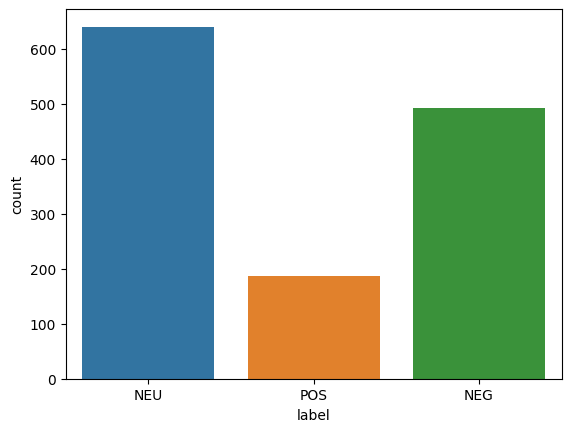

In [ ]:
#se imprime un grafico que evidencia los comentarios positivos, negativos y neutrales
x = df.Comment
y = df.label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

**Nube de palabras**

In [ ]:
#se listan las palabras sin polaridad o menor relevancia
stopwordlist = ['un', 'una','que' ,'unos', 'unas', 'el','y','que', 'la','de', 'los', 'las', 'lo', 'al', 'del', 'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante',
                'en','El','este','lo','ya','te','x','se','Y','así','DE','e','por']

In [ ]:
#metodo para limpiar las palabras menos relevantes
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['clean_text'] = df['clean_text'].apply(lambda text: cleaning_stopwords(text))
df['clean_text'].head()

0                                                 🐯🇦🇷🦆
1    Ojalá Gane Milei, Perú pasó mismo tan solo 40m...
2                                                  🔥🔥🔥
3                                   Ojalá gana Milei 🙌
4    Me encanta tu sombrero vultiao! De origen colo...
Name: clean_text, dtype: object

In [ ]:
#lista de comentarios limpios
comments_list = df['clean_text'].tolist()
# Imprimir solo 5 comentarios para visualizar la lista
comments_list[:5]

['🐯🇦🇷🦆',
 'Ojalá Gane Milei, Perú pasó mismo tan solo 40mil votos ganó analfabeto castillo.',
 '🔥🔥🔥',
 'Ojalá gana Milei 🙌',
 'Me encanta tu sombrero vultiao! De origen colombiano 🇨🇴']

In [ ]:
# una lista de todos las palabras registradas en los comentarios
# Separamos las palabras de cada comentario
words_list = [string.split(" ") for string in comments_list]

# Combinamos las listas de palabras en un solo arreglo
all_words = []
for words in words_list:
    all_words.extend(words)

all_words = [string.strip() for string in all_words]

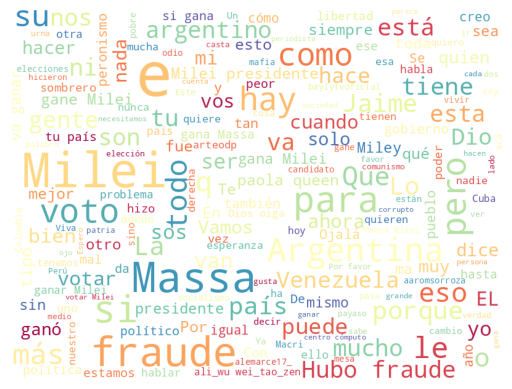

In [ ]:
# Creamos un objeto WordCloud
wordcloud = WordCloud(width=800, height=600, background_color="white",
                        min_font_size=10, max_font_size=100,
                        colormap="Spectral")

# Generamos la nube de palabras
wordcloud.generate(" ".join(all_words))

# Mostramos la nube de palabras
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

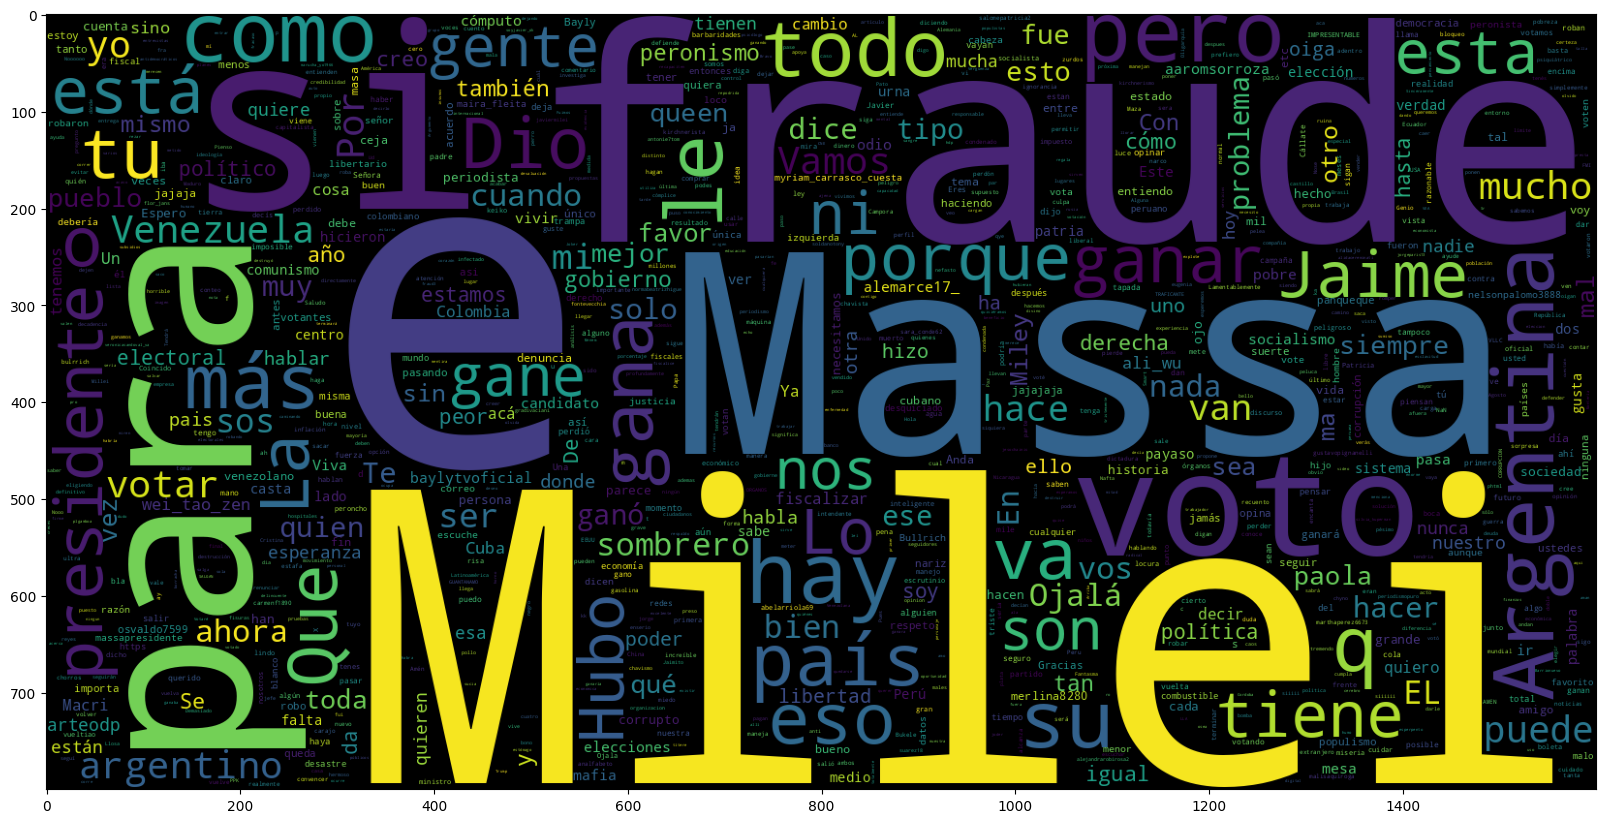

In [ ]:
#El código crea una nube de palabras visualmente atractiva que muestra la frecuencia de las palabras en una lista de comentarios.
#Esta representación permite identificar rápidamente las palabras más comunes y
#su relevancia en el contexto de los comentarios

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(comments_list))
plt.imshow(wc)

# **Procesamiento de los datos para la evaluación de los algoritmos de Machine Learning**

In [ ]:
data=df[['clean_text','label']]

In [ ]:
# Canbiar los valores "POS" del label a el valor 1
data['label'] = data['label'].replace("POS",1)
# change from -1 (negative) to 0
data['label'] = data['label'].replace("NEG",0)

#solo se usaran los comentarios positivos y negativos
dataset = data[data['label'].isin([1, 0])]

dataset.head()

<ipython-input-193-6c4af0c4b3e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace("POS",1)
<ipython-input-193-6c4af0c4b3e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace("NEG",0)


,clean_text,label
4,Me encanta tu sombrero vultiao! De origen colo...,1
6,"Que buena análisis, excelente sombrero",1
7,problema es fraude,0
12,Eres Único E Irrepetible,1
14,Hubo fraude!! No logramos sacarnos más encima ...,0


In [ ]:
# cambiar nombre de las columnas para ser más entendibles
dataset['target'] = dataset['label']
dataset['text'] = dataset['clean_text']
dataset = dataset[['text','target']]

# convertir la etiqueta a un valor entero
dataset['target'] = pd.to_numeric(dataset['target'], errors='coerce', downcast='integer')

<ipython-input-194-7184d4a3cb65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['label']
<ipython-input-194-7184d4a3cb65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['clean_text']
<ipython-input-194-7184d4a3cb65>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

# **Separación de los textos y etiquetas de entrada.**

In [ ]:
# Separación de los textos y etiquetas de entrada.
X=dataset.text
y=dataset.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =26105111)

# **Transformación de conjunto de datos usando TF-IDF Vectorizer**

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# **Metodo para evaluar el modelo**

In [ ]:
def evaluacion_modelo(model):
  y_pred = model.predict(X_test)

  #Imprimir las métricas de evaluación del conjunto de datos.
  print("Metrics")
  print(classification_report(y_test, y_pred))

  # Calcular y representar la matriz de confusión
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negativo','Positivo']
  group_names = ['Verdadero Neg','Falso Pos', 'Falso Neg','Verdadero Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Valores previstos", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Valores reales" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Matriz de confusión", fontdict = {'size':18}, pad = 20)

# **Evaluación del modelo Linear Support Vector Classification (LinearSVC)**



Metrics
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        97
           1       0.88      0.54      0.67        39

    accuracy                           0.85       136
   macro avg       0.86      0.75      0.78       136
weighted avg       0.85      0.85      0.83       136



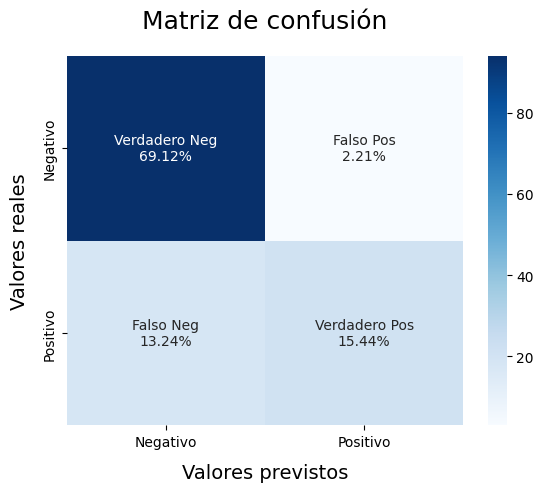

In [ ]:
# Ejecutar el modelo
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
evaluacion_modelo(SVCmodel)